# Module 8 - Lab 
## 2015-2016 NFL Football Season - Making A Beautiful Scatter Plot with R
This is a step-by-step breakdown of a thought process for building a nice looking scatter plot using ggplot2 in R. This analysis uses a dataset containing information on every play in the 2015-2016 NFL football season  [https://www.kaggle.com/maxhorowitz/nflplaybyplay2015](https://www.kaggle.com/maxhorowitz/nflplaybyplay2015) here on Kaggle. 
This season culminated in Super Bowl L in which the Denver Broncos defeated the Carolina Panthers 24-10. 
It was also the last professional football game for the legendary Peyton Manning. 
Not a bad way to go out.

In this exploration we will take a look at some simple summary statistics of the various teams over the regular season and see if any interesting insights come out as to what made the Broncos/Panthers the final two standing for the year. 
We will build a scatter plot comparing the total offensive and defensive production of each team and use some simple web scraping to add the team colors to the visualization.

#### Data Analysis
First, load the relevant packages. 
We will use the usual `dplyr` and `tidyr` for data frame manipulation, `magrittr` for the two-way chaining operator, `lubridate` for working with dates, and `ggplot2` for visualizations.

In [1]:
library(tidyr)
library(dplyr)
library(magrittr)
library(lubridate)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



Read in the CSV file and let’s see what we have



In [2]:
df <- data.frame(read.csv('/dsa/data/all_datasets/NFLPlaybyPlay2015.csv', stringsAsFactors = FALSE))
df$Date <- as.Date(df$Date)
str(df)

'data.frame':	46129 obs. of  66 variables:
 $ X                 : int  36 51 72 101 122 159 180 199 236 261 ...
 $ Date              : Date, format: "2015-09-10" "2015-09-10" ...
 $ GameID            : int  2015091000 2015091000 2015091000 2015091000 2015091000 2015091000 2015091000 2015091000 2015091000 2015091000 ...
 $ Drive             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ qtr               : int  1 1 1 1 1 1 1 1 1 1 ...
 $ down              : int  NA 1 1 2 1 1 1 2 2 3 ...
 $ time              : chr  "15:00" "15:00" "14:21" "14:04" ...
 $ TimeUnder         : int  15 15 15 15 14 13 13 12 11 11 ...
 $ TimeSecs          : int  3600 3600 3561 3544 3506 3462 3425 3380 3353 3328 ...
 $ PlayTimeDiff      : int  0 0 39 17 38 44 37 45 27 25 ...
 $ SideofField       : chr  "NE" "PIT" "PIT" "PIT" ...
 $ yrdln             : int  35 20 38 47 49 35 24 32 42 36 ...
 $ yrdline100        : int  35 80 62 53 49 35 24 32 42 36 ...
 $ ydstogo           : int  0 10 10 1 10 10 10 18 28 22 ...
 $ ydsnet      

There’s a ton of information here. It seems every play of every game in the regular season is catalogued. Each game has a GameID and the Date on which it was played. The offense and defense teams are given by posteam and DefensiveTeam, respectively. There’s also the time on the clock, current down and distance, type of play, special teams information, information on the players involved, etc. It’s really tempting to explore this in great detail, but for the purposes of this demonstration, let’s keep it simple. We will organize things a bit and create some summary statistics.

NFL games usually, but not always, are played on Sundays, so they are instead grouped by week. First, We will assign the week number to each game relative to the first game of the season.

In [3]:
df %<>%
  mutate(week = as.numeric(df$Date - df[1,'Date'])%/%7 + 1)

Let’s breakdown the overall offensive/defensive performance for each team to see which was the driving factor behind the Bronco’s victory. 
To start we will compare the total yards of offense per game, the total yards given up defensively per game, and the average number of points scored per game. We can get to these values by grouping the data by posteam or DefensiveTeam and aggregating Yards.Gained to get the total number of yards in the season. Dividing by the number of unique GameID’s for each team gets the average (just in case some teams played more games than others).

Defense first as it is a little simpler:

In [4]:
def <- df %>% 
  filter(!is.na(DefensiveTeam)& DefensiveTeam!='') %>%
  group_by(DefensiveTeam) %>% 
  summarise(def_ypg = sum(Yards.Gained[Penalty.Yards==0]) / n_distinct(GameID)) %>%
  arrange(def_ypg)
def <- data.frame(def)
def

DefensiveTeam,def_ypg
<chr>,<dbl>
DEN,315.8750
SEA,368.0625
BAL,373.0625
DAL,375.4375
CAR,388.2500
HOU,389.6250
TEN,390.4375
ATL,390.7500
ARI,391.1875


Spoiler alert – Denver had an amazing defense this year.

Now for the offense. The total yards per game is calculated essentially the same as for defense, but the total number of points scored per game (ppg) requires a little manipulation, as teams can score in any of the following ways:

Touchdown (6 points), Extra Point (1 point), Two-point Conversion (2 points), or Field-Goal (3 points). 
In R this can be done as:

In [5]:
off <- df %>% 
  filter(!is.na(posteam) & posteam!='') %>%
  group_by(posteam) %>% 
  summarise(off_ypg = sum(Yards.Gained[Penalty.Yards==0]) / n_distinct(GameID),
            ppg=(   sum(Touchdown*6, na.rm=TRUE) +
                    sum(ifelse(ExPointResult=="Success",1,0),na.rm=TRUE) + 
                    sum(ifelse(TwoPointConv=="Success",2,0),na.rm=TRUE)  +  
                    sum(ifelse(FieldGoalResult=="Good",3,0),na.rm=TRUE))/ n_distinct(GameID)) %>%
  arrange(desc(ppg))                                                 
off <- data.frame(off)
off

posteam,off_ypg,ppg
<chr>,<dbl>,<dbl>
CAR,401.6875,27.1875
NE,415.0000,26.8125
ARI,456.8125,26.2500
CIN,405.0625,25.2500
PIT,437.8750,23.8750
NYJ,443.8750,23.6250
SEA,442.8750,23.5625
NYG,431.9375,23.1875
JAC,410.0000,23.0000


If you’re fact checking me you may wonder why these numbers are different than what was reported for the year [i.e., Cardinals were second in ppg, not third](http://www.pro-football-reference.com/teams/crd/2015.htm). However, note I’ve only calculated the points scored by the offense. The missing points are from kickoff returns for TD, pick-sixes, safeties, etc.

Now let’s combine these two to get the stats for each team in one place.

In [6]:
nfl <- def %>%
  inner_join(off,by=c('DefensiveTeam'='posteam')) %>%
  rename(Team=DefensiveTeam) %>%
  arrange(Team)
nfl

Team,def_ypg,off_ypg,ppg
<chr>,<dbl>,<dbl>,<dbl>
ARI,391.1875,456.8125,26.2500
ATL,390.7500,427.6875,19.8125
BAL,373.0625,416.6250,19.4375
BUF,401.4375,407.6250,21.4375
CAR,388.2500,401.6875,27.1875
CHI,400.4375,398.4375,21.6250
CIN,421.8750,405.0625,25.2500
CLE,439.6250,412.6250,16.3750
DAL,375.4375,380.8125,17.3750


Let’s make a scatter plot with defense on one axis and offense on the other. To add an extra dimension, we will make the size of the points indicate the average points per game

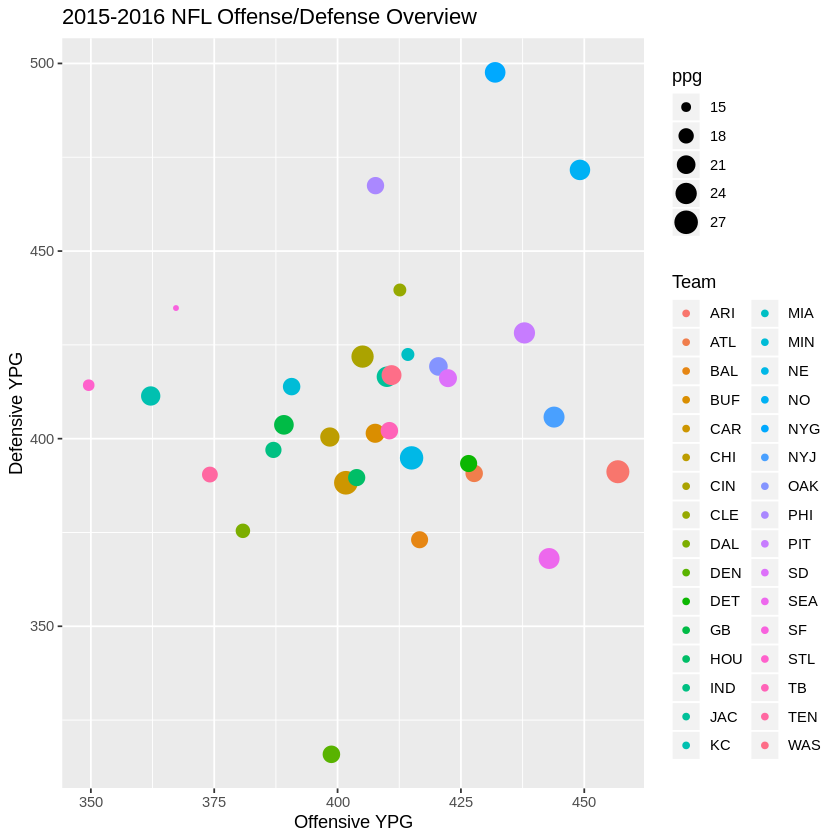

In [7]:
plt <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg)) +
   labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG")
plt

That’s an okay start, but the default colors, although pretty, are kind of confusing in this context. It would look a lot better if we colored each data point using the actual team colors. Time for some simple web searching.

#### Coloring Data by Team Color
Below we create a color scheme for the NFL teams based on thier team color. 

In [8]:
color.scheme <- c("#97233F", "#C9233F", "#2A0365", "#0F4589", "#0088D4", "#DF6108", "#F03A16", "#322820",
  "#0D254C", "#DF6108", "#006DB0", "#313F36", "#B20032", "#163F83", "#007198", "#B20032",
 "#005E6A", "#3B0160", "#0D254C", "#C9B074", "#192E6C", "#313F36", "#C4C8CB", "#003B48",
 "#F2C800", "#0B264D", "#54BA4C", "#840026", "#0D254C", "#B20032", "#4C96C4", "#7A2D39")

Finally, let’s apply this color scheme to our plot. The aesthetic color palette in ggplot2 can be controlled using scale_color_manual.

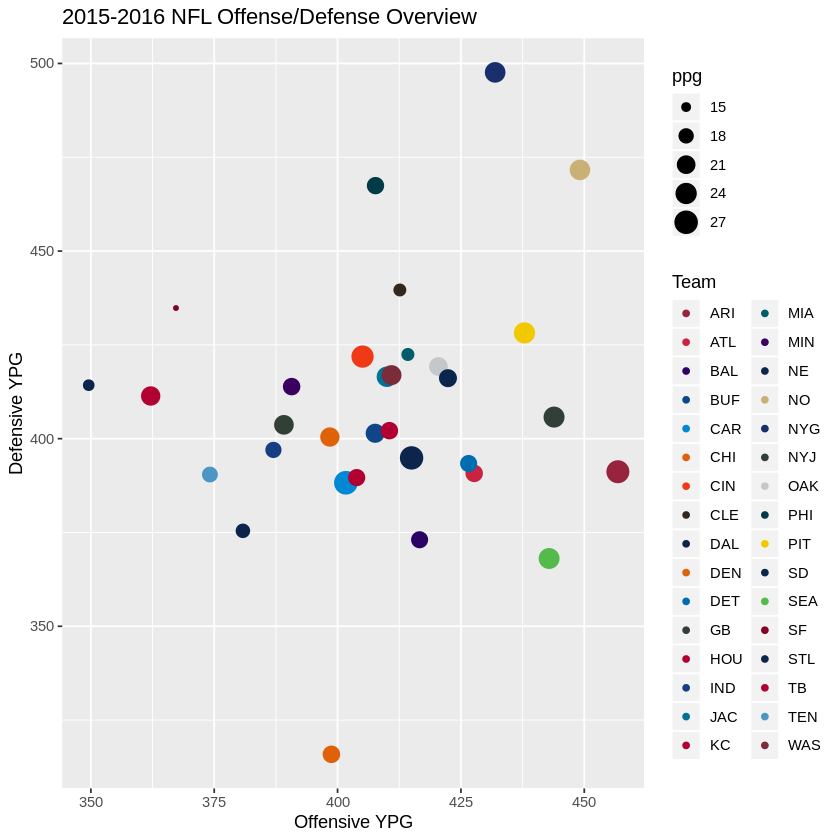

In [9]:
plt <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg)) +
  labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG")  + scale_color_manual(values=color.scheme) 
plt

Awesome, it worked. Now to touch up this plot to make it look nice.

Let’s remove the color legend in favor of text labels. The labels can be added with a <code>geom_text</code>

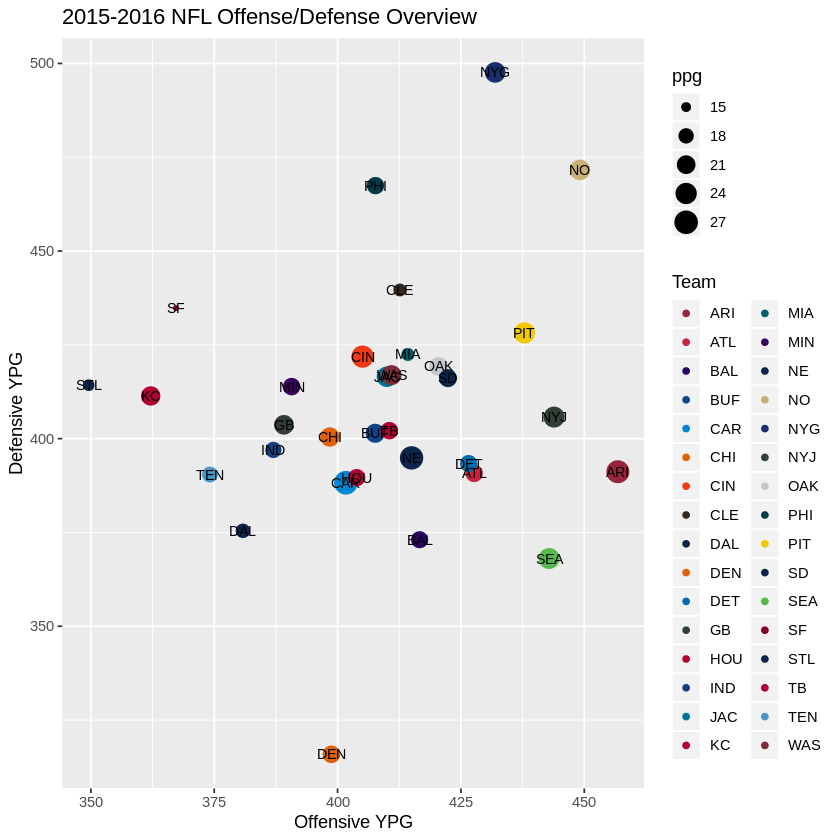

In [10]:
plt <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg)) +
  labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG")  + scale_color_manual(values=color.scheme) +
  geom_text(aes(label=Team),size=3.0) 
plt

The bubbles are too small for some datapoints (poor 49ers….). 
We will make things a bit bigger.

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

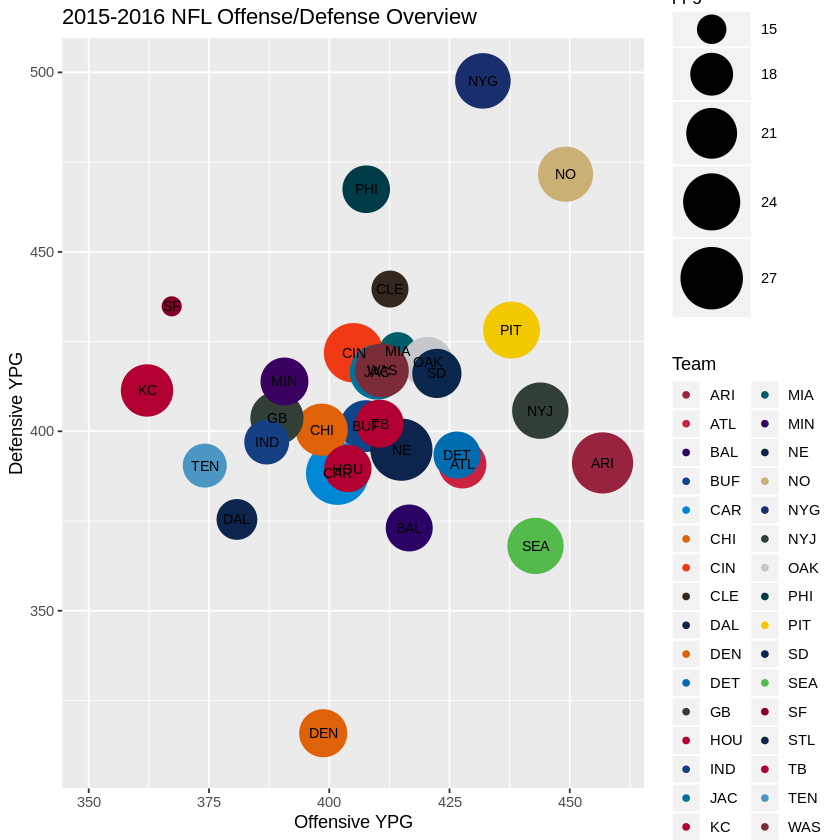

In [11]:
plt <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg)) +
  labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG")  + scale_color_manual(values=color.scheme) +
  geom_text(aes(label=Team),size=3.0)  + 
  xlim(350, 460) + ylim(310,500) +  scale_size(range=c(5,17))
plt

I’d prefer the background to be clean, so let’s remove the grid lines and use theme_bw() to make the background white.

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

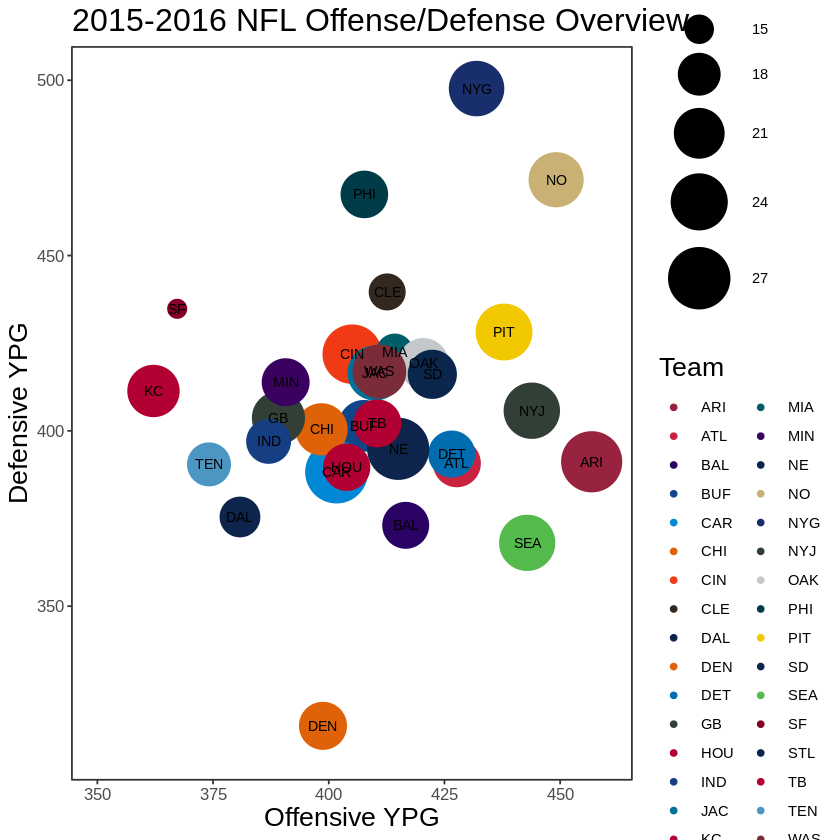

In [12]:
plt <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg)) +
  labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG")  + scale_color_manual(values=color.scheme) +
  geom_text(aes(label=Team),size=3.0)  +
  theme_bw() + xlim(350, 460) + ylim(310,500) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=10), title=element_text(size=16)) +
  scale_size(range=c(5,17)) 
plt

Now let’s remove the color legend and move the size legend to the bottom.

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

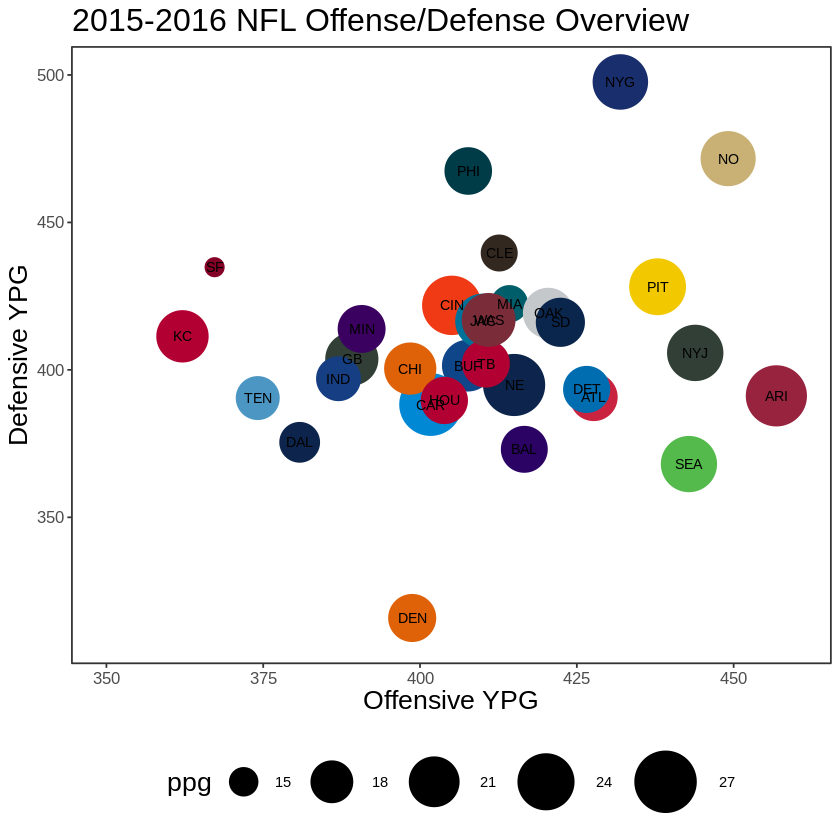

In [13]:
plt <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg)) +
  labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG")  + scale_color_manual(values=color.scheme) +
  geom_text(aes(label=Team),size=3.0)  + 
  theme_bw() + xlim(350, 460) +
  ylim(310,500) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=10), title=element_text(size=16)) +
  scale_size(range=c(5,17)) +
  guides(color=FALSE) +
  theme(legend.position = "bottom")
plt

Moving the legend freed up some space, so we will slightly resize the labels. Lastly, let’s deal with the cluttered overlapping points by adding some transparency, which is called alpha in most software.

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

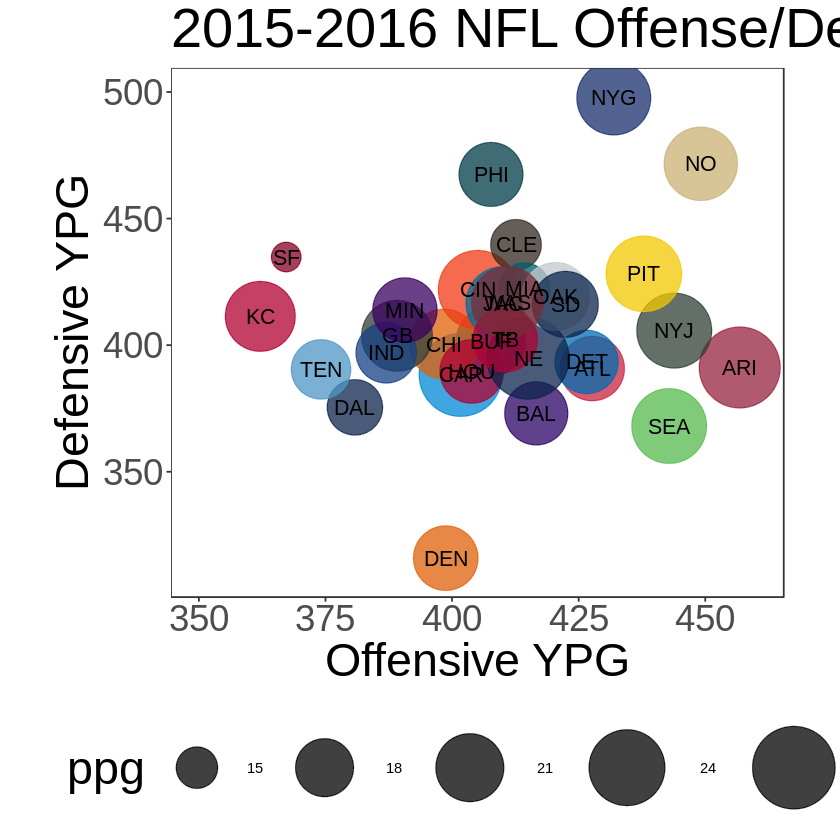

In [14]:
plt <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg),alpha=0.75) +
labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG")  + scale_color_manual(values=color.scheme) +
  geom_text(aes(label=Team),size=4.5)  + 
  theme_bw() + xlim(350, 460) + ylim(310,500) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=22), title=element_text(size=28)) +
  scale_size(range=c(8,23)) + guides(color=FALSE) + theme(legend.position = "bottom")
plt + coord_fixed(ratio = .5)

It is getting there! 

Now that we did all that work, what can we learn from a plot like this? 
On such a plot, it’s better to be low and right, meaning your defense doesn’t give up many yards and your offense is producing well. 
Although many teams are sort of middle-of-the-road, the Broncos defense really stands out, 
and many would agree this was the driving force behind their Super Bowl win. 
Peyton Manning is one of the best to ever play the game, holding the all-time record for touchdown passes, passing yards, and overall wins. 
He is surely destined for the Hall-of-Fame; however, his performance in his final season was somewhat mediocre in comparison. 
Luckily, the Broncos had Super Bowl MVP Von Miller to contribute. 
Looks like defense made the difference this season.

We could also invert the y-axis so that the the top-right quadrant is the ideal region. This can be done with scale_y_reverse()

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

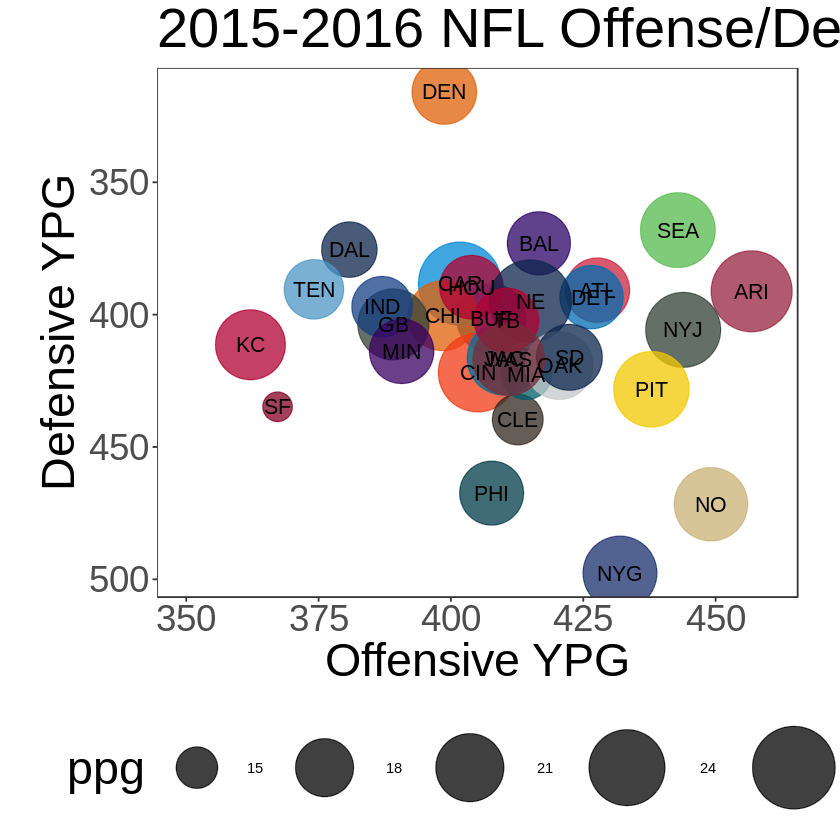

In [15]:
plt <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg),alpha=0.75) +
labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG") + 
  scale_color_manual(values=color.scheme) +
  geom_text(aes(label=Team),size=4.5)  + 
  theme_bw() + xlim(350, 460) + ylim(310,500) + scale_y_reverse() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=22), title=element_text(size=28)) +
  scale_size(range=c(8,23)) + guides(color=FALSE) + theme(legend.position = "bottom")
plt + coord_fixed(ratio = .5)

### Moving Toward A Story 
Now, if we want to use this graphic to tell a story focused on a particular team, we can modify the color scheme to focus attention on one team or another. For example, lets say we are interested in how the teams in the NFC North fared last season.  Those teams are 
    1. The Green Bay Packers
    2. The Chicago Bears
    3. The Minnesota Vikings 
    4. The Detroit Lions
One thing we might do is shade out the other teams, but leave them in the grid for rough comparisons. And keep the colors for the NFC North teams, so they stand out. 

#### Color Assignment
The colors are assigned by the order teams are listed in the Data Frame "NFL". So, we relist that frame.

In [16]:
nfl

Team,def_ypg,off_ypg,ppg
<chr>,<dbl>,<dbl>,<dbl>
ARI,391.1875,456.8125,26.2500
ATL,390.7500,427.6875,19.8125
BAL,373.0625,416.6250,19.4375
BUF,401.4375,407.6250,21.4375
CAR,388.2500,401.6875,27.1875
CHI,400.4375,398.4375,21.6250
CIN,421.8750,405.0625,25.2500
CLE,439.6250,412.6250,16.3750
DAL,375.4375,380.8125,17.3750


Teams 6, 11, 12 & 18 are in the NFC North.  So, we assign "white" as the color for all the other teams, leaving the NFC North in place. Note that we changed the variable from "color.scheme" to "color.scheme.nfcNorth". This will be changed as the variable when we recreate the graph. 

We can find the hex code for white by a quick search of "color for white" on google : [This is one link I found](http://www.w3schools.com/colors/colors_names.asp). The Color for White is "#FFFFFF". 

In [17]:
color.scheme.nfcNorth <- c("#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#DF6108", "#FFFFFF", "#FFFFFF",
  "#FFFFFF", "#FFFFFF", "#006DB0", "#313F36", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF",
 "#FFFFFF", "#3B0160", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF",
 "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF")

#### Keeping Work By Changing Variable Names:
Note that we are keeping previous work by 
1. changing "plt" to "plt.NFCN"
2. changing "color.scheme" to "color.scheme.nfcNorth"

By doing this, we can still run the old "plt" pplot that we created earlier without reordering my code. This is a good way to experiment with storytelling without frustrating yourself. 

In [18]:
color.scheme.nfcNorth

[1] "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#DF6108" "#FFFFFF"
 [8] "#FFFFFF" "#FFFFFF" "#FFFFFF" "#006DB0" "#313F36" "#FFFFFF" "#FFFFFF"
[15] "#FFFFFF" "#FFFFFF" "#FFFFFF" "#3B0160" "#FFFFFF" "#FFFFFF" "#FFFFFF"
[22] "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF"
[29] "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF"

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

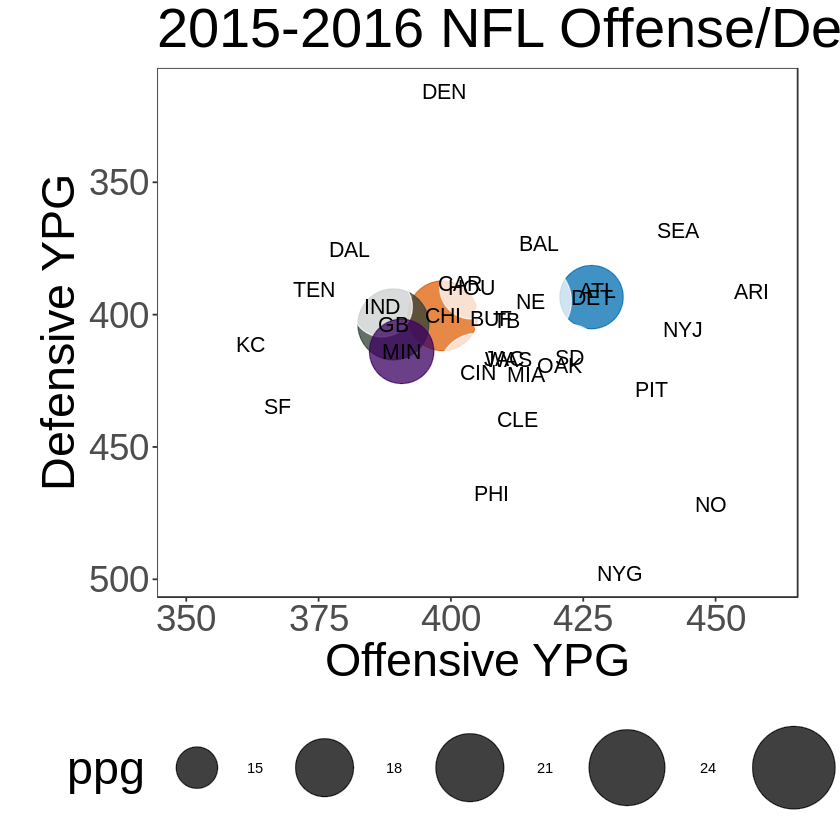

In [19]:
plt.NFCN <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg),alpha=0.75) +
labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG") + 
  scale_color_manual(values=color.scheme.nfcNorth) +
  geom_text(aes(label=Team),size=4.5)  + 
  theme_bw() + xlim(350, 460) + ylim(310,500) + scale_y_reverse() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=22), title=element_text(size=28)) +
  scale_size(range=c(8,23)) + guides(color=FALSE) + theme(legend.position = "bottom")
plt.NFCN + coord_fixed(ratio = .5)


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

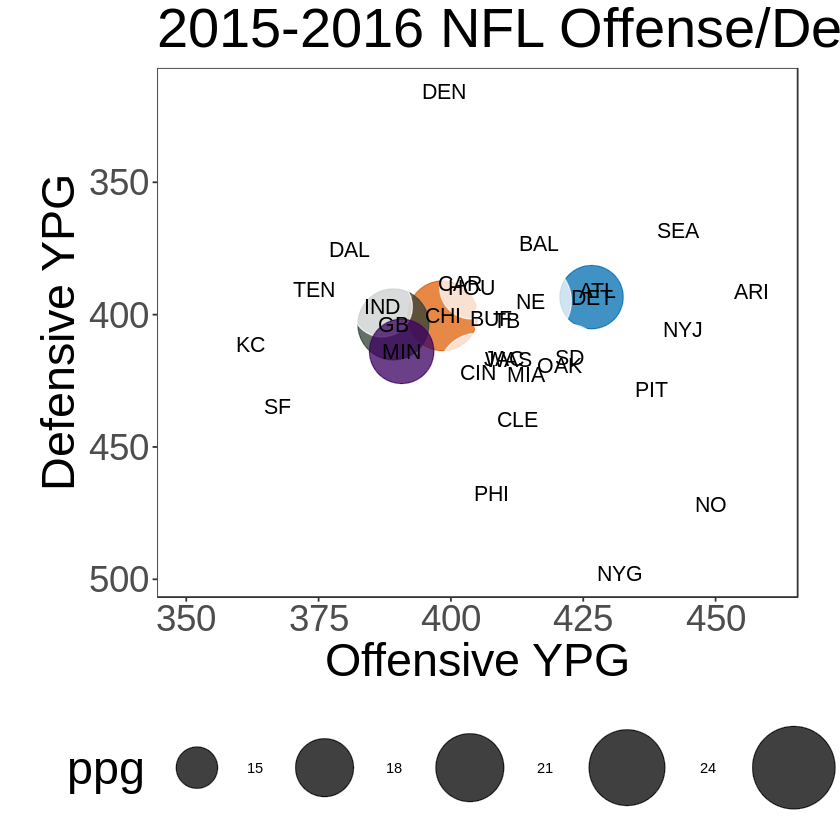

In [20]:
plt.NFCN <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg),alpha=0.75) +
labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG") + 
  scale_color_manual(values=color.scheme.nfcNorth) +
  geom_text(aes(label=Team),size=4.5)  + 
  theme_bw() + xlim(350, 460) + ylim(310,500) + scale_y_reverse() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=22), title=element_text(size=28)) +
  scale_size(range=c(8,23)) + guides(color=FALSE) + theme(legend.position = "bottom")

plt.NFCN + coord_fixed(ratio = .5)

#### Fixing Overplotted Names, Part 1
Now when we see the plot, we have the names of the teams too close together. 

It's harder to read than I like.

So, we want to have the titles move around to overplot each other less. The first thing we do is :

1. Look up geom_text on the [GGPLOT2 Documentation](https://web.dsa.missouri.edu/static/PDF/R/ggplot2.pdf) 
2. I identify "nudge_x" and "nudge_y" as binary parameters that do exactly what I want
3. I add these options into geom_text as follows : geom_text(aes(label=Team),size=4.5, nudge_x=TRUE, nudge_y=TRUE) 

You can see this in the code below on the fourth line. 

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

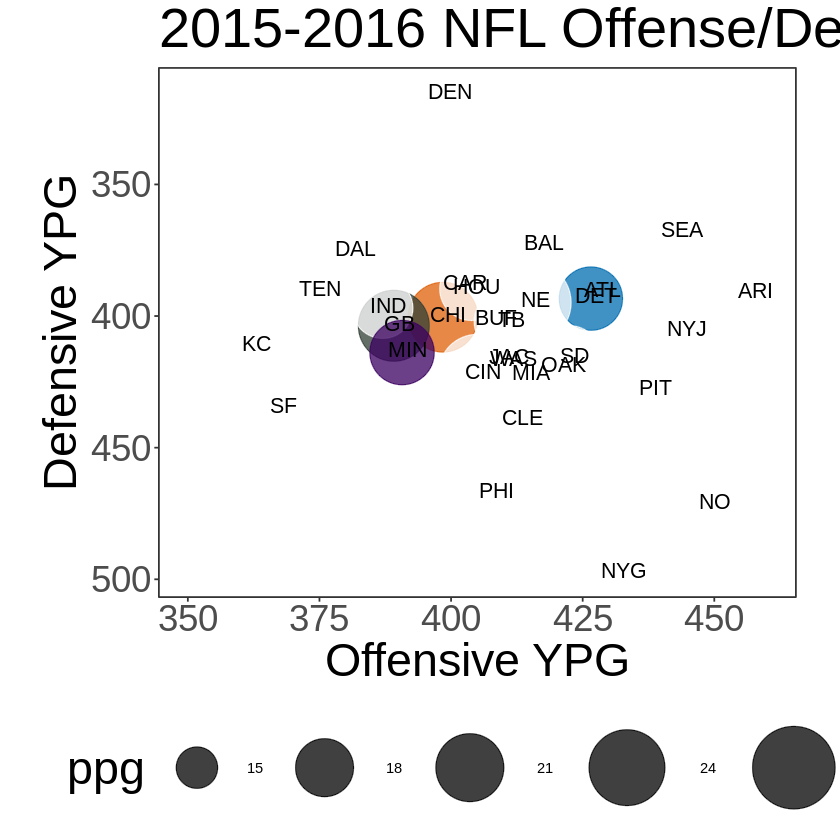

In [21]:
plt.NFCN <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg),alpha=0.75) +
labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG") + 
  scale_color_manual(values=color.scheme.nfcNorth) +
  geom_text(aes(label=Team),size=4.5, nudge_x=TRUE, nudge_y=TRUE)  + 
  theme_bw() + xlim(350, 460) + ylim(310,500) + scale_y_reverse() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=22), title=element_text(size=28)) +
  scale_size(range=c(8,23)) + guides(color=FALSE) + theme(legend.position = "bottom")
plt.NFCN + coord_fixed(ratio = .5)

#### Fixing Overplotted Names, Part 2
They still seem a little too close together for my comfort, so we will reduce the font size.
    
I also think the plotted title is too large, and we will fix that as well.
    
    1. We will reduce the size of the team abbreviations by changing "size=4.5" on line 4 to "size=3"
    2. On line 7, we change the font sizes in the theme as follows:
        - theme(axis.text=element_text(size=14, title=element_text(size=18) 

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

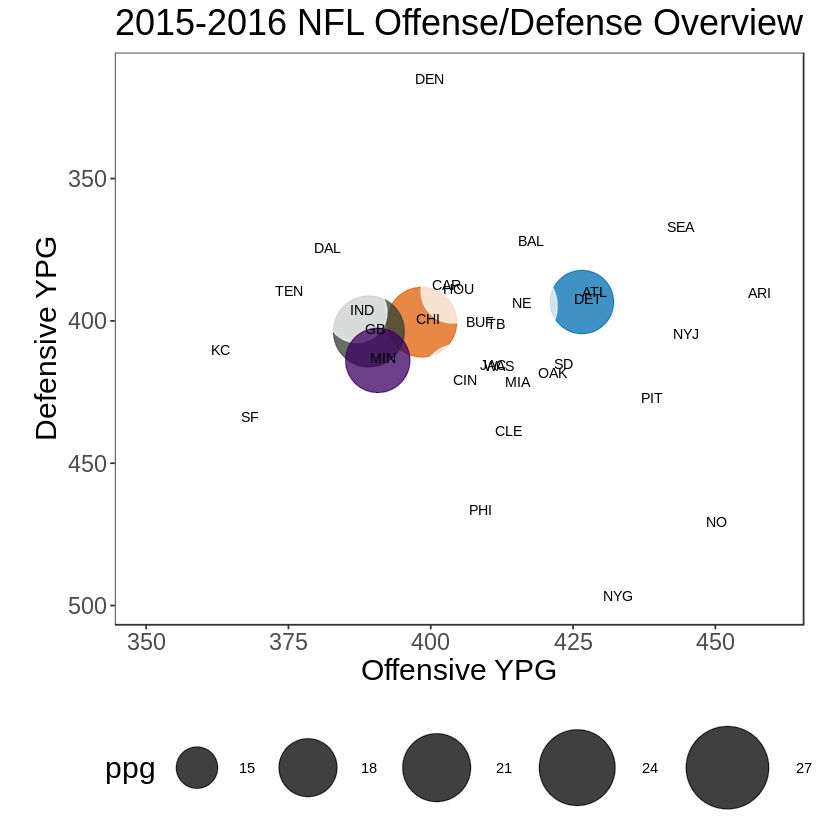

In [22]:
plt.NFCN <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg),alpha=0.75) +
labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG") + 
  scale_color_manual(values=color.scheme.nfcNorth) +
  geom_text(aes(label=Team),size=3, nudge_x=TRUE, nudge_y=TRUE)  + 
  theme_bw() + xlim(350, 460) + ylim(310,500) + scale_y_reverse() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=14), title=element_text(size=18)) +
  scale_size(range=c(8,23)) + guides(color=FALSE) + theme(legend.position = "bottom")
plt.NFCN + coord_fixed(ratio = .5)

Finally, the fonts are too light for the darker colors that Minnesota and Green Bay have, and since they are by far the two best teams in the NFC North, they must be addressed. 

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

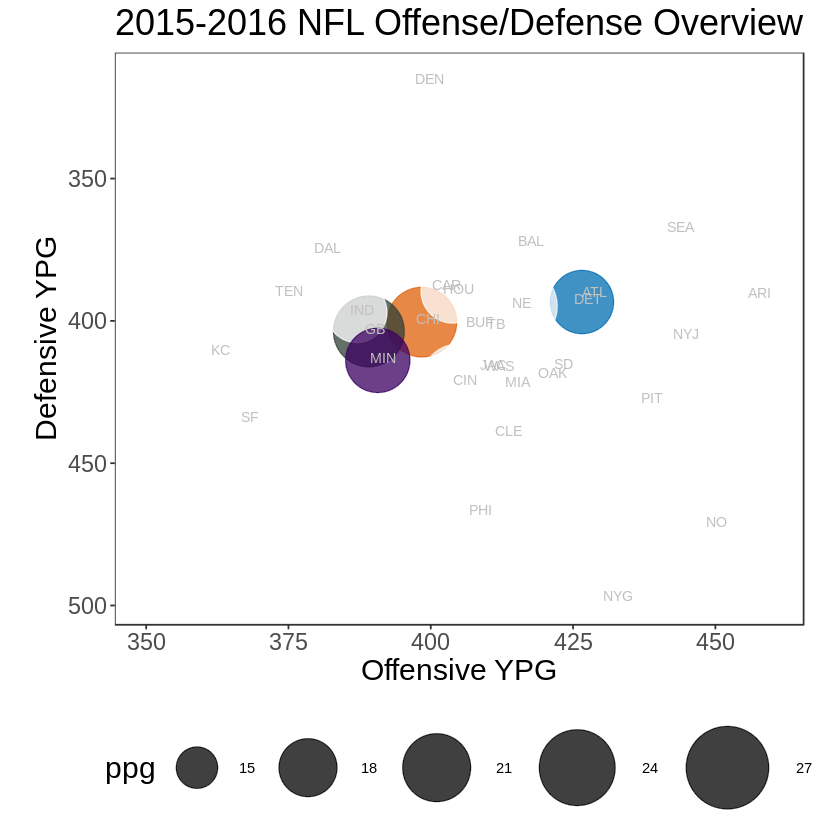

In [23]:
plt.NFCN <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg),alpha=0.75) +
labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG") + 
  scale_color_manual(values=color.scheme.nfcNorth) +
  geom_text(aes(label=Team),size=3, color="#C0C0C0", nudge_x=TRUE, nudge_y=TRUE)  + 
  theme_bw() + xlim(350, 460) + ylim(310,500) + scale_y_reverse() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=14), title=element_text(size=18)) +
  scale_size(range=c(8,23)) + guides(color=FALSE) + theme(legend.position = "bottom")
plt.NFCN + coord_fixed(ratio = .5)

#### Indianapolis and Houston and New England and Carolina: You're Plotting Bothers ME!

You can see that we are starting to tell the story of the NFC North a bit more clearly, but the other teams remain too similar. Too close. 

I elect to fix this by changing the font color again, this time to white. Now all the teams except those in the NFC North and those that overlap those teams, do not have visible lables. And I can really begin to tell the story of the NFC North. I also make the sizes of the circles in a broader range, from 1, 23 instead of 8, 23.

 - geom_text(aes(label=Team),size=3, color="#FFFFFF", nudge_x=TRUE, nudge_y=TRUE)  
 - scale_size(range=c(1,20))




Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

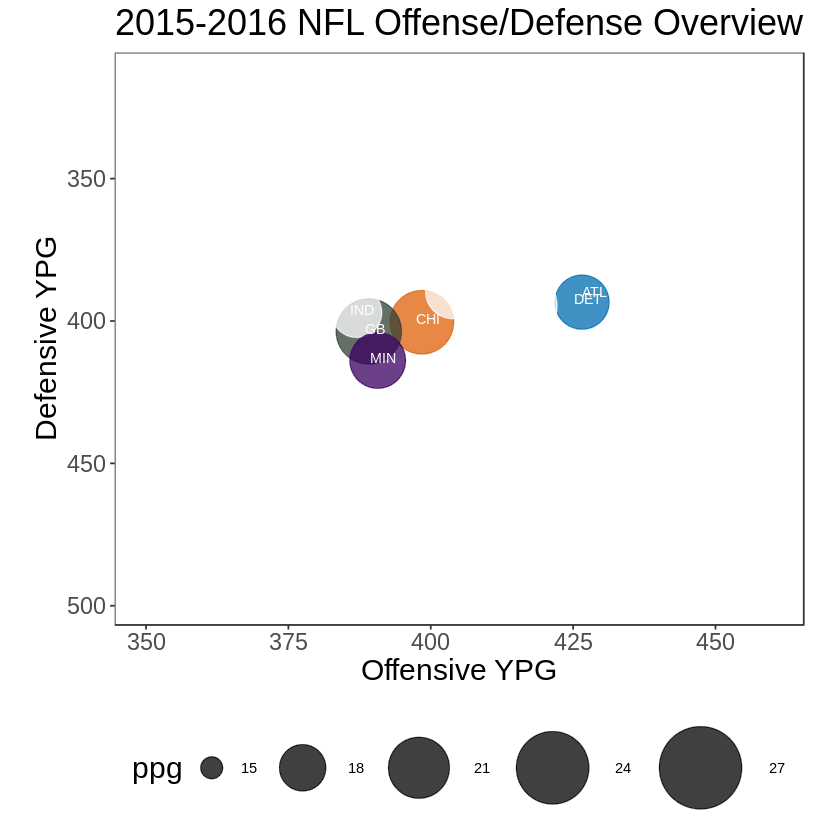

In [24]:
plt.NFCN <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg),alpha=0.75) +
labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG") + 
  scale_color_manual(values=color.scheme.nfcNorth) +
  geom_text(aes(label=Team),size=3, color="#FFFFFF", nudge_x=TRUE, nudge_y=TRUE)  + 
  theme_bw() + xlim(350, 460) + ylim(310,500) + scale_y_reverse() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=14), title=element_text(size=18)) +
  scale_size(range=c(1,23)) + guides(color=FALSE) + theme(legend.position = "bottom")
plt.NFCN + coord_fixed(ratio = .5) 

### The Story of the NFC North in 2015

In 2015, the Minnesota Vikings won the NFC North. The question is how and why. A deeper dive into all the statistics might tell a very nuanced story, but sometimes [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor) is the best and most useful way to understand what happens. First, lets look at the final standings: 

![NFCNorthStandings Missing](../images/NFCNorthStandings.png)

Now, lets take a look at the yardage gained by each team's offense, the yardage given up by each team's defense, and the relative total points per game (ppg). 

(note: we do this simply by calling the image developed above, "plt.NFCN + coord_fixed(ratio = .5)"


Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

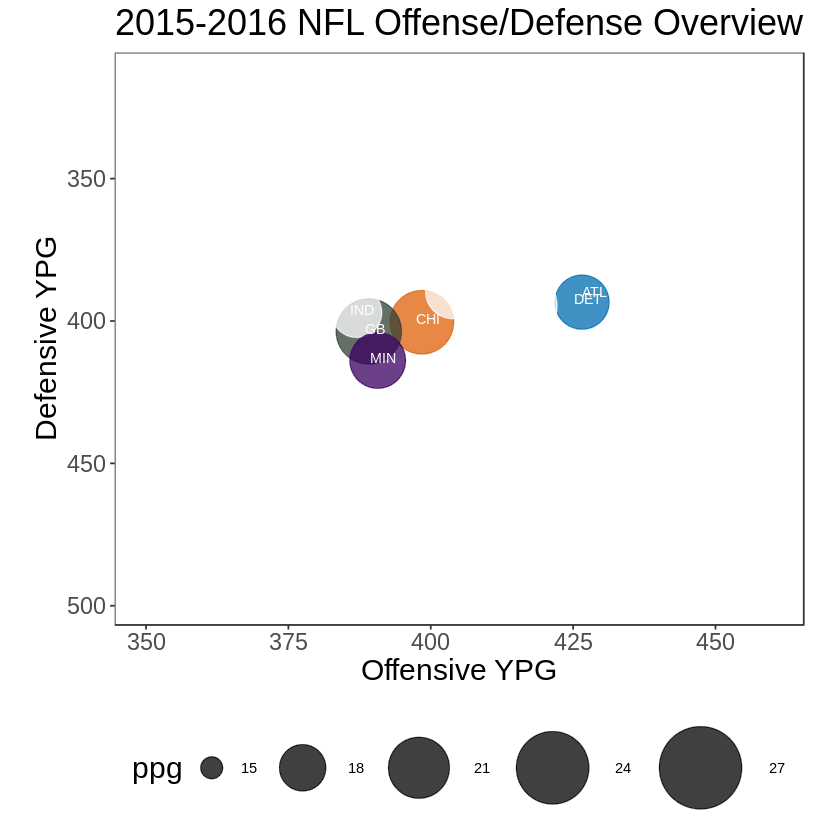

In [25]:
plt.NFCN + coord_fixed(ratio = .5) 


Here's what we see: 

1. The Minnesota Vikings and Detroit Lions each scored around the same points 
2. The Vikings had the highest defensive yards allowed.
3. The Packers had the fewest offensive yards per game, and did not do as well as the Bears or Lions at preventing teams from gaining yards on them
4. By the traditional adage, "Defense wins championships", the NFC North does not appear to make any sense at all in 2015. 

At least not statistically! 

Let's look at these teams in the context of all the other teams. 

(Here, we inverse our NFC North Focused Color Scheme from earlier, making them BLACK, and the other teams their original colors)


In [26]:
color.scheme.nfl <- c("#97233F", "#C9233F", "#2A0365", "#0F4589", "#0088D4", "#000000", "#F03A16", "#322820",
  "#0D254C", "#DF6108", "#000000", "#000000", "#B20032", "#163F83", "#007198", "#B20032",
 "#005E6A", "#000000", "#0D254C", "#C9B074", "#192E6C", "#313F36", "#C4C8CB", "#003B48",
 "#F2C800", "#0B264D", "#54BA4C", "#840026", "#0D254C", "#B20032", "#4C96C4", "#7A2D39")

Note that I am changing the color of the font to something readable, other than white, for the NFC North Teams benefit. 

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

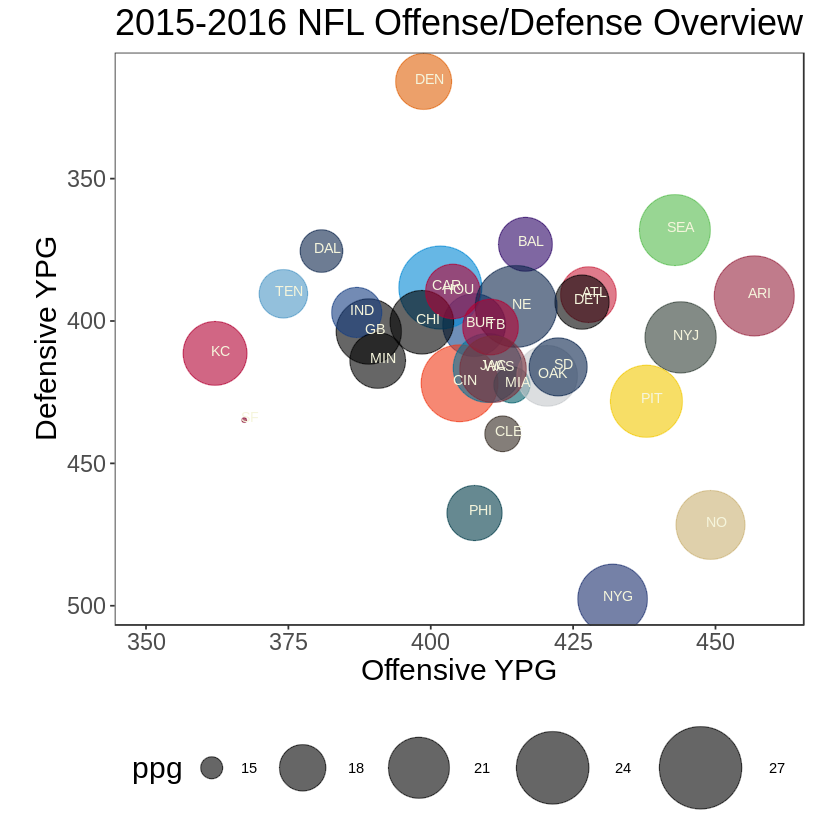

In [27]:
plt.nfl <- ggplot(data=nfl,aes(x=off_ypg,y=def_ypg)) + geom_point(aes(color=Team, size=ppg),alpha=0.6) +
labs(title="2015-2016 NFL Offense/Defense Overview",x="Offensive YPG", y="Defensive YPG") + 
  scale_color_manual(values=color.scheme.nfl) +
  geom_text(aes(label=Team),size=3, color="#F5F5DC", nudge_x=TRUE, nudge_y=TRUE)  + 
  theme_bw() + xlim(350, 460) + ylim(310,500) + scale_y_reverse() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(axis.text=element_text(size=14), title=element_text(size=18)) +
  scale_size(range=c(1,23)) + guides(color=FALSE) + theme(legend.position = "bottom")
plt.nfl + coord_fixed(ratio = .5) 

### The Story of the NFC North in 2015: Conclusion

Following [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor) we can have further clarity on why no NFC North Team advanced to the NFC Championship game: 

![Image Missing](../images/playoffs.png)

You can see that, although the data within this mediocre (as it turns out) division does not help explain, easily and simply, the final divisional record, putting the division in the context of the rest of the league makes it fairly clear that defense wins championships. 

The high scoring Carolina Panthers did lose to the "give up the fewest points by far" Denver Broncos in the Superbowl that year.

Putting the NFC North in the context of the larger league helps us understand their relative futility as a group. More analysis, likely on a game by game basis, will be required to make sense of what happened there within the division. 

**At the League Level**, it's also noteworthy that the team who gained the most yards faced off with the team who gave up the least yards in the Super Bowl. 


*** Note this story would be made much better if the visuals would have been brought down into the story and not left the reader to go hunt and find what the writer was referring to. 

